# Mechanistic Interpretability
**TAs: Michael Hanna & Oskar van der Wal**

**Notebook Credits:**
- This notebook was created by Michael Hanna and Oskar van der Wal.
- It is based heavily on a [demo notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb), by Neel Nanda, creator of TransformerLens.

In this workshop, you will learn about **mechanistic interpretability**, a subfield of interpretability that seeks to develop a low-level, causal understanding of neural networks. You will work with individual attention heads and neurons, and develop a causal model of how transformer models process gender bias.
- **Overview**: This workshop has two main goals:
    1. Learning how to use [TransformerLens](https://github.com/neelnanda-io/TransformerLens), a library for performing causal interventions on transformer models.
    2. Investigating problems in gender bias, discovering the components of GPT-2 responsible for producing biased output.
    Both parts of the workshop will focus primarily on gender bias, but can easily be applied to other phenomena.
- **Learning Objectives**:
    - Gain a solid understanding of TransformerLens models and functionalities.
    - Learn a variety of mechanistic interpretability techniques, and how to implement them in TransformerLens models.
    - Develop a deeper understanding of transformers based on the *residual stream* and *circuits views* of transformers.
    - Grow your confidence in designing precise experiments that reveal low-level causal structures at work in transformer based models.
- **About the assignments:**
    - Assignments are marked with a symbol ☑️, 📊, and 🧠 depending on the type of task. **The ones marked with an extra ✍️ and called ToSubmit have to be handed in.**
    - The answers should be provided in a PDF document -- but check Canvas for the exact requirements.

---
⚠️**Before starting this notebook:**⚠️
- [ ] Change the runtime to GPU (`Runtime -> Change runtime type -> Hardware Accelator -> GPU`).

## 0 Setup
Just run this code -- don't bother reading it.

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install circuitsvis

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
    !wget https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_male_stereo.json
    !wget https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_female_stereo.json
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-w3ijekn_
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-w3ijekn_
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 3cd943628b5c415585c8ef100f65989f6adc7f75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-06-27 11:08:53--  https://raw.githubusercontent.com/sebastianGehrmann/CausalMediationAnalysis/master/experiment_data/professions_male_stereo.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.gith

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("world")

# Import stuff
import torch
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional, Tuple
from functools import partial
import json


import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
from typing import List, Tuple, Dict, Union, Optional, Callable, Any
from time import ctime
import einops
import torch
import numpy as np
from copy import deepcopy
from collections import OrderedDict
import pickle
from subprocess import call
from IPython import get_ipython

ipython = get_ipython()
if ipython is not None:
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if not torch.cuda.is_available():
    print("WARNING: Running on CPU. Did you remember to set your Colab accelerator to GPU?")
torch.set_grad_enabled(False)

## 1 Introduction

TransformerLens is a powerful interpretability library for working with pre-trained transformer-based NLP models.

The primary benefit of TransformerLens is that it allows you to easily interact with model representations and components at a low-level. For example, you can:
- run a forward pass on the model and save attention head outputs, attention patterns, neuron activations, etc.
- intervene on the model during a forward pass, selecting a specific component (attention head, MLP, neuron) and changing its inputs or outputs.

The second point is crucial. Mechanistic interpretability relies heavily on **causal interventions**: making changes to model internals, and observing changes in model behavior. When we develop a hypothesis, we will verify it by making targeted changes to our model, and ensuring that the corresponding behavioral changes are what we expect. This stands in contrast to many other interpretability techniques, which do not causally verify their interpretations.

TransformerLens is implemented in PyTorch, so models should feel similar to those you have used before. So far, it supports primarily autoregressive models (e.g., GPT-2), but other models (like BERT) are being added. Models must be ported to TransformerLens before use.

If you have any questions regarding TransformerLens, I encourage you to first consult the [TransformerLens repo](https://github.com/neelnanda-io/TransformerLens).

### Loading and Running Models
To begin, we will simply load and run a pre-trained model, `gpt2-small`. By setting `model_name` to other values, you can load other models (but for the purposes of this notebook, do not do so). See other valid model names [here](https://neelnanda-io.github.io/TransformerLens/model_properties_table.html).

In [ ]:
model_name = 'gpt2-small'
model = HookedTransformer.from_pretrained(model_name, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


Now, we can run the model! Models can be run on a single string or a tensor of tokens (shape: [batch, position], all integers), and the possible return types are:

- "logits" (shape [batch, position, d_vocab], floats),
- "loss" (the cross-entropy loss when predicting the next token),
- "both" (a tuple of (logits, loss))
- None (run the model, but don't calculate the logits - this is faster when we only want to use intermediate activations)

In TransformerLens, models and tokenizers are bundled together, so we don't always have to tokenize separately. You can access the tokenizer via `model.tokenizer`.

In [ ]:
model_description_text = """## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. See my explainer for documentation of all supported models, and this table for hyper-parameters and the name used to load them. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly.

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!"""
loss = model(model_description_text, return_type="loss")
print("Model loss:", loss)

Model loss: tensor(4.1307, device='cuda:0')


Now we begin our investigations into gender bias! In this first simple example, we'll be looking at model behavior, in a very surface-level way: the top-*k* tokens that are most likely to come next in the sentence.

#### 1.1 ☑️ ToDo
Write a function that takes in a `torch.Tensor` of `logits` for one example (shape: `[sequence_length, vocab_size]`) and an `int` `k`, and returns a `k`-element list representing the top-`k` most likely next tokens, and their probabilities. For the purposes of this exercise, just compute two lists: the top-`k` most likely next tokens (`topk_tokens`), and their probabilities (`topk_probs`).

To write this, you'll need to use the `model.tokenizer` to `decode` vocabulary indices into tokens (strings).

In [ ]:
def topk(logits: torch.Tensor, k: int) -> List[Tuple[str, float]]:
    """
    TODO: implement topk
    """
    logits_last_layer = logits[-1, :] #solvedTODO: check if we should only use the last layer -> yes
    logits_last_layer = torch.softmax(logits_last_layer, dim = 0) #solvedTODO: check if we should use softmax -> yes
    assert torch.allclose(torch.sum(logits_last_layer), torch.tensor(1.))

    topk_probs, topk_inds = torch.topk(logits_last_layer, k)
    topk_tokens = [model.tokenizer.decode(topk_ind,  add_prefix_space=False) for topk_ind in topk_inds] # TODO: how to remove prefix space?

    return list(zip(topk_tokens, topk_probs))

Now, we will observe bias in action, in a real language model. Run the following examples, and see how they reveal GPT-2's biases regarding professions (doctors and nurses).

In [ ]:
s1 = "The nurse said that"
logits1 = model(s1, return_type="logits").squeeze(0)
print(s1)
for token, prob in topk(logits1, 5):
    print(f'"{token}"', '\t', f'{prob:.2f}')


s2 = "The doctor said that"
logits2 = model(s2, return_type="logits").squeeze(0)
print(s2)
for token, prob in topk(logits2, 5):
    print(f'"{token}"', '\t', f'{prob:.2f}')

The nurse said that
" she" 	 0.19
" the" 	 0.08
" her" 	 0.06
" while" 	 0.05
" when" 	 0.05
The doctor said that
" he" 	 0.14
" the" 	 0.10
" she" 	 0.05
" his" 	 0.04
" while" 	 0.03


Clearly, "nurse" induces GPT-2 to output more female pronouns, while "doctor" elicits more male pronouns. This particular example doesn't 100% prove that GPT-2 is biased—these pronouns don't have to refer back to the subject of the sentence -- but in the absence of any other context, it's the most likely explanation.

But why does this happen? This is a multifaceted question that has been studied from many different angles. In this notebook we'll try to answer the question "How does GPT-2 small implement these biases?", but there are many other ways of researching this; ask TA Oskar for more details.

## 2 Observational Analysis
In this section, we'll try to understand how GPT-2 implements gender biases by observing its internal structure and activations. We won't make any causal changes, but will hope to form hypotheses via *post-hoc interpretation*.

Before we get started, we need to make a little dataset to start with.

In [ ]:
# We're going to load up some examples.
with open("professions_female_stereo.json", 'r') as f:
    female_stereo_professions = [x[0] for x in json.load(f)]

with open("professions_male_stereo.json", 'r') as f:
    male_stereo_professions = [x[0] for x in json.load(f)]

# ensure that they're single tokens
female_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in female_stereo_professions]
female_stereo_professions = [x for x, l in zip(female_stereo_professions, female_stereo_professions_lens) if l == 1]

male_stereo_professions_lens = [len(model.tokenizer.encode(f' {x}')) for x in male_stereo_professions]
male_stereo_professions = [x for x, l in zip(male_stereo_professions, male_stereo_professions_lens) if l == 1]

# slot them into our sentences
female_stereo_sentences = [f"The {profession} said that" for profession in female_stereo_professions]
male_stereo_sentences = [f"The {profession} said that" for profession in male_stereo_professions]

The first step in such observational analysis is to store all of the model's activations. This will allow us to easily reference and study them later on. In TransformerLens, you can do this like so:

In [ ]:
# convert our sentences into tokens
female_stereo_toks = model.to_tokens(female_stereo_sentences)
male_stereo_toks = model.to_tokens(male_stereo_sentences)
model.cfg.use_attn_result = True
gpt2_logits, gpt2_cache = model.run_with_cache(female_stereo_toks)

### Working with activations

The `ActivationCache` object, which we've instantiated as `gpt2_cache`, stores all of the activations from running many sentences of the form `"The {profession} said that"`, where `profession` is a female-stereotyped profession; e.g. `"The nurse said that"`. But what are all of these activations? It turns out that there are a whole lot of activations in a GPT-2 model—now, you'll learn which activations are stored, and how they're named in the cache.

To understand this, let's first have a look at the architecture of GPT-2. As you may well know, it consists of transformer layers; each block is composed of a causally masked multi-head attention block, followed by an MLP / FFN block. Each block has a residual connection around it, and has a LayerNorm layer prior to the main part of the block (but after the residual connection).


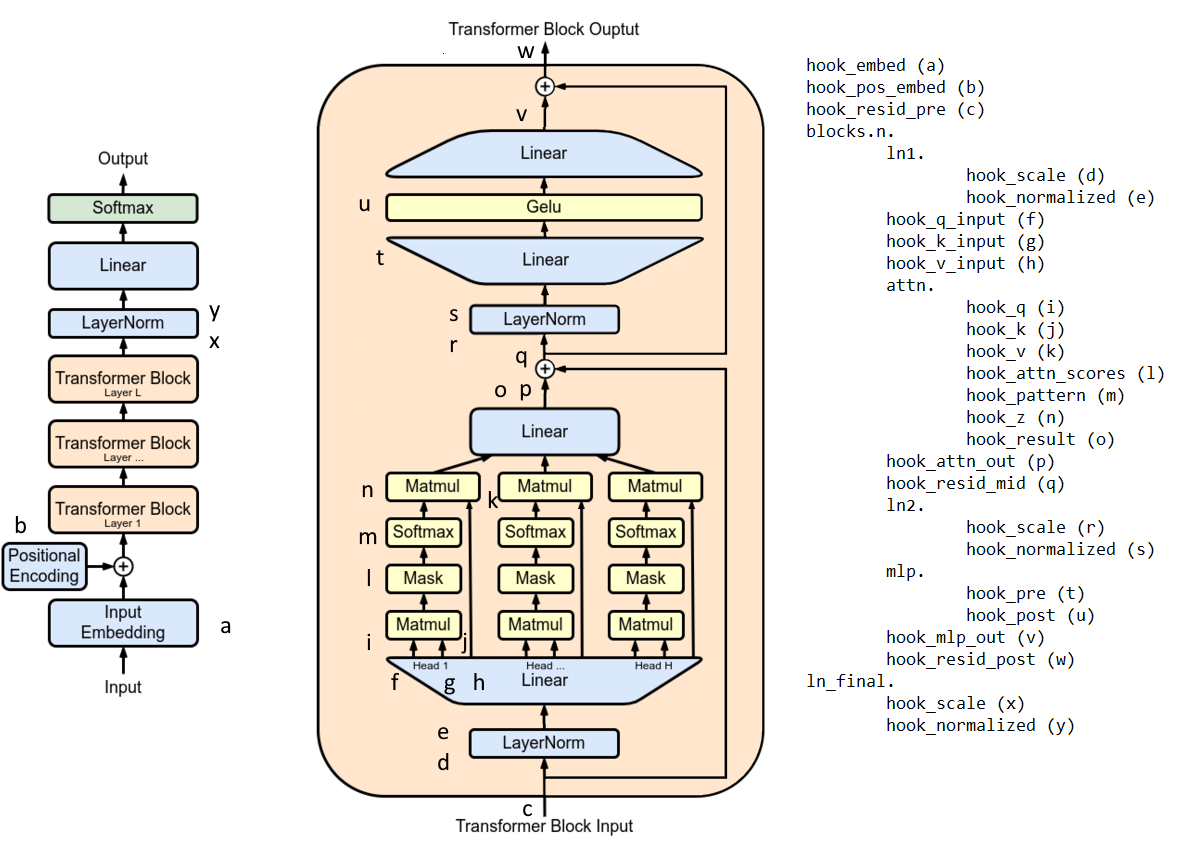

**Figure 1:** Left: Schematic of a Transformer model. Middle: More detailed schematic of the Transformer Block. Right: Names of the components in TransformerLens, where the letters (`a`,`b`,`c`, etc.) refer to the annotated components in images on the left. Image adapted from [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Full_GPT_architecture.png/800px-Full_GPT_architecture.png).

The image in Figure 1 breaks down each block of the transformer layer into its individual components, which are mostly represented within the cache we saw earlier. But what maps to what, and what's in the cache? You can examine the structure of an individual block by running the line below, `model.blocks[0]`. You can also directly inspect the cache's keys via `gpt2_cache.keys()`.

In [ ]:
model.blocks[0]

TransformerBlock(
  (ln1): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (ln2): LayerNormPre(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (attn): Attention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn_scores): HookPoint()
    (hook_pattern): HookPoint()
    (hook_result): HookPoint()
  )
  (mlp): MLP(
    (hook_pre): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_q_input): HookPoint()
  (hook_k_input): HookPoint()
  (hook_v_input): HookPoint()
  (hook_attn_out): HookPoint()
  (hook_mlp_in): HookPoint()
  (hook_mlp_out): HookPoint()
  (hook_resid_pre): HookPoint()
  (hook_resid_mid): HookPoint()
  (hook_resid_post): HookPoint()
)

In [ ]:
gpt2_cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_in', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'block

We've annotated the image above with the precise naming conventions used in TransformerLens. Note that to retrieve something in a transformer block from the cache, you must specify the block; e.g. for the `hook_mlp_out` of the 7th layer (0-indexed), you would use `gpt2_cache['blocks.7.hook_mlp_out']`.

<details>
<summary>What are hooks?</summary>

Did you notice that these are called **hooks**? Hooks are places where you can inject custom functions to manipulate the model's behaviour. This becomes handy when we want to do causal intervention at a low level during the forward passess! We will come back to this in section 3, but for now, we will only extract information from the hook points.

Note that in the image, the input multiplication steps (e.g. $Q = W_Q * x$) are bundled in with the $Q$/$K$/$V$ (query, key, value) matrix multiplication steps (e.g. $Q*K$). `i,j,k` refer to the creation of $Q$,$K$,$V$ from the inputs, which are `f,g,h`. `l` is the output of $Q*K/\sqrt d$, i.e. the raw scores of the attention head, pre-causal-masking.
</details>

Also note that there are two different ways of interpreting attention. In one, we take the dot product of the attention distribution and the values $V$, and get (for each head and query) a $d_v$-dimensional vector. We then concatenate the head outputs together, and multiply them by $W_O$ to get a $d_{model}$-dimensional vector. We can also directly multiply each of the aforementioned $d_v$-dimensional vectors by the corresponding rows in $W_O$ to get a $d_{model}$-dimensional vector for each head; after doing this, we sum the vectors for each head to get the same $d_{model}$-dimensional output. In TransformerLens, you can choose which version you would like to cache: if you want the $d_v$-dimensional vectors that have not been multiplied by $W_O$, set `model.cfg.use_attn_result=False`; set it to `True` to consume more GPU memory, but get the other behavior. We choose the latter as they will come in handy later.

Finally note that in the image, LayerNorms are not broken into their components, but TransformerLens stores the intermediate scaling value (var(x) + epsilon) as `hook_scale`, while the output of the LayerNorm is `hook_normalized`.

⚠️ **Are you able to read the schematic?** ⚠️

#### ☑️ 2.1 ToDo
For each activation description commented below, write an expression that extracts it from the cache. Some activations might need a little manipulation post-extraction to get precisely what we ask for.

In [ ]:
assert model.cfg.use_attn_result == True

# The positional encodings
key = gpt2_cache['hook_pos_embed']
print(key.shape)

# The input to the transformer block at layer 2
assert (gpt2_cache['blocks.1.hook_resid_post'] == gpt2_cache['blocks.2.hook_resid_pre']).all()
key = gpt2_cache['blocks.2.hook_resid_pre']
print(key.shape)

# The output of attention layer 10 (without the residual connection)
# TODO: Which one is it? -> With hidden representations
key = gpt2_cache['blocks.10.attn.hook_result']
print(key.shape)
key = gpt2_cache['blocks.10.hook_attn_out']
print(key.shape)

# The output of the LayerNorm preceding the MLP in layer 8
# TODO: Which one is it? -> Output of block
key = gpt2_cache['blocks.2.mlp.hook_pre']
print(key.shape)
key = gpt2_cache['blocks.2.ln2.hook_normalized']
print(key.shape)

# The attention scores of the attention heads in layer 11
# raise NotImplementedError

# Thea attention pattern of attention head 9 of layer 1 at the end position
# raise NotImplementedError

# The 3rd-position activation of neuron 512 of MLP 6, post-GeLU
# raise NotImplementedError

torch.Size([29, 5, 768])
torch.Size([29, 5, 768])
torch.Size([29, 5, 12, 768])
torch.Size([29, 5, 768])
torch.Size([29, 5, 3072])
torch.Size([29, 5, 768])


#### 🧠 2.2 ToSubmit 1 ✍️
In the first week, you studied Transformer embeddings returned by the `output_hidden_states` functionality of RoBERTa and Wav2Vec. Look at the analogous [functionality in HuggingFace's GPT-2 implementation](https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutput.hidden_states).

**Then, answer the following questions in 1 sentence each (no more!). In your report, please `enumerate` the list as done here. Consider reading the "Logit Lens" and "Residual Stream" sections before answering:**

1. Which hook point does the output given by `return_hidden_states` correspond to, for the layer n=7?

2. Do the hidden states of a given layer correspond exclusively to output computed by components in that layer? Or do they contain information from other layers' components as well?

3. If we wanted to analyze the output of a specific component of a given layer (say the MLP in layer n=7), which hook point should we take representations from?

4. Think about probing the representations from (1) and (3). If you can extract a given piece of information from (3) with an linear probe, are you guaranteed to be able to extract it from (1) with a (potentially distinct) linear probe as well?

### Attention Analysis

Hopefully, after that exercise, you feel comfortable retrieving these activations from the cache. Now, it's time to use these stored activations to analyze your models! To begin, we'll perform an analysis of GPT-2's attention. Perhaps by finding those heads that most attend to the profession, we can find those that introduce the bias into GPT-2's output (e.g., "nurse" and "doctor" being associated with the pronouns "she" and "he", respectively).

We'll now look at GPT-2's attentions when processing the sentence: `"<|endoftext|>The actress said that"`.

Note that in the following visualizations, the row indicates the word that the model is processing (the query position), while the column indicates the position attended to (the key/value position). Darker colors indicate more attention is given to the given key/value position at the given query position. By looking at the final row, we can see what the model attended to at the "that" position. It is at this position that the biased output is created.

To start, we'll look at layer 0. But consider looking at the other layers (1--11) as well! Do you see any particularly suspect attention heads?

In [ ]:
sentence_index = 0
layer = 0
attention_pattern = gpt2_cache[f"blocks.{layer}.attn.hook_pattern"][sentence_index]
gpt2_str_tokens = model.to_str_tokens(female_stereo_sentences[sentence_index])

print(f"Layer {layer} Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

Layer 0 Head Attention Patterns:


After this exercise, you might have found some heads that attend to the profession—or maybe not. Either way, this isn't a super efficient way of going about things; you can't always be examining every individual attention head. But, we do want to know which heads attend where.

#### ☑️ 2.3 ToDo
Let's solve this problem programmatically, by sorting the heads by the mean attention (over examples) they pay to the profession. More concretely, implement a function that, given a `gpt2_cache`, and an integer `query_index` and `key_index`, computes two lists.

The first is a list of heads sorted by attention paid to the specified `key_index`, at the `query_index` position. Each head is a `Tuple[int, int]`, where each tuple is a `(layer, head)` pair representing one attention head.

The second list is a `torch.Tensor` containing the specific values of attention paid by each head.

In [ ]:
query_index, key_index = 3, 2

n_layers, n_heads, n_sentences = 12, 12, 29
attention_pattern = torch.stack([gpt2_cache[f"blocks.{layer}.attn.hook_pattern"][:, :, query_index, key_index] for layer in range(n_layers)])
assert attention_pattern.shape == (n_layers, n_sentences, n_heads)
attention_pattern = torch.permute(attention_pattern, (0, 2, 1))
attention_pattern = torch.mean(attention_pattern, dim = 2)
attention_pattern.shape

torch.Size([12, 12])

In [ ]:
def sort_heads(gpt2_cache: ActivationCache, query_index: int, key_index: int) -> List[Tuple[Tuple[int,int], float]]:
    # TODO: Implement sort_heads

    n_layers, n_heads, n_sentences = 12, 12, 29
    attention_pattern = torch.stack([gpt2_cache[f"blocks.{layer}.attn.hook_pattern"][:, :, query_index, key_index] for layer in range(n_layers)])
    assert attention_pattern.shape == (n_layers, n_sentences, n_heads)
    attention_pattern = torch.permute(attention_pattern, (0, 2, 1))
    attention_pattern = torch.mean(attention_pattern, dim = 2)

    attention_pattern_flat = attention_pattern.view(-1)
    sorted_attention_pattern, sorted_indices = torch.sort(attention_pattern_flat, descending = True)
    sorted_attention_pattern = sorted_attention_pattern.tolist()
    sorted_indices = sorted_indices.tolist()

    heads = [(index // n_heads, index % n_heads) for index in sorted_indices]
    assert len(heads) == len(sorted_attention_pattern)
    assert torch.tensor([(attention_pattern[heads[idx]] == sorted_attention_pattern[idx]).item() for idx in range(len(heads))]).all()

    # return heads, sorted_attention_pattern
    return list(zip(heads, sorted_attention_pattern))


# Show which attention heads attended the most to index 2 ("actress") at the end position (-1)
print(sort_heads(gpt2_cache, -1, 2)[:5])

[((4, 3), 0.8288394808769226), ((2, 9), 0.591220498085022), ((3, 6), 0.4923422336578369), ((0, 6), 0.3875313401222229), ((2, 0), 0.3017062842845917)]


### Logit Lens
At this point, we've identified some attention heads that might be transferring information from the profession position (i.e. the position of "nurse" or "actress") to the end position of the sentence. But how can we know what these attention heads are actually doing? Perhaps they're not transferring gender information at all; attention tells us nothing about this.

One way of answering this quesion is via the [**logit lens**](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens). This point of view notes that to produce its logits, GPT-2 simply passes the output of the final transformer block through a LayerNorm, and multiplies it by the (un)embedding matrix.

However, this procedure can be sensibly applied to many intermediate outputs too. The outputs of the attention heads and MLPs have this same dimensionality, and these too can be translated into logit space via the same transformation. Doing so won't give us real logits, but it can tell us what parts of the vocabulary the model is upweighting or downweighting.

#### ☑️ 2.4 ToSubmit 2 ✍️
Implement logit lens as function that, given a `representation` (with batch and hidden dimensions) and `unembed_matrix` (with hidden and vocab_size dimensions), multiplies them together to get the logit lens of the representations. We'll ignore the LayerNorm for now (but feel free to add it in if you'd like!).

Then, get the representations of each attention head from the cache and model, and apply the logit lens on them. Finally, use these to see which heads upweight the relevant tokens " she" over " he" the most. **Submit a table with the top 5 layer+heads combinations and the logit lens diff using the code we provide you.**

In [ ]:
# TODO: implement logit lens (easy, one-liner)
def logit_lens(representation: Float[torch.Tensor, "batch dimension"], unembed_matrix: Float[torch.Tensor, "dimension vocab_size"]) -> Float[torch.Tensor, "batch vocab_size"]:
    return torch.matmul(representation, unembed_matrix)

In [ ]:
# actually getting the representations in TransformerLens
unembed_matrix = model.unembed.W_U
representations = torch.cat([gpt2_cache[f"blocks.{layer}.attn.hook_result"].mean(0)[-1] for layer in range(12)], dim=0)

In [ ]:
# Performing logit lens, and extracting she - he upweighting
logit_lenses = logit_lens(representations, unembed_matrix)

she_token = model.tokenizer.encode(' she')[0]
he_token = model.tokenizer.encode(' he')[0]

she_token_logit_lenses = logit_lenses[:, she_token]
he_token_logit_lenses = logit_lenses[:, he_token]
logit_lens_diff = she_token_logit_lenses - he_token_logit_lenses

heads = [(layer, head) for layer in range(12) for head in range(12)]
values, indices = logit_lens_diff.sort(descending=True)
heads_increasing_she = list(zip([heads[i] for i in indices], values.tolist()))
print(heads_increasing_she[:5])


[((10, 9), 6.636244773864746), ((5, 9), 2.169347047805786), ((9, 7), 2.1001524925231934), ((6, 4), 1.729724645614624), ((0, 9), 1.6890709400177002)]


Huh, those aren't the same heads as before. So what is the logit difference induced by the heads with high attention to the profession-position?

In [ ]:
for head, _ in sort_heads(gpt2_cache, -1, 2)[:5]: #solvedTODO: what's key and query idxs? -> yes, add -1
    print(head, logit_lens_diff[head[0] * 12 + head[1]]) #solvedTODO: What are those? -> The flattened idxs


(4, 3) tensor(0.8617, device='cuda:0')
(2, 9) tensor(-0.3611, device='cuda:0')
(3, 6) tensor(0.0190, device='cuda:0')
(0, 6) tensor(-0.9471, device='cuda:0')
(2, 0) tensor(0.3340, device='cuda:0')


#### 📊 2.4 ToSubmit 3 ✍️
Only some of these heads actually boost the logits of " she" highly. How do other heads compare? First, make a heatmap showing, for each (layer, head), the logit differences. We've given you most of the code - just fill in the labels so we know you've understood what's going on!

Then, make a histogram displaying the distribution of logit differences across heads. Discuss the results in the caption. Is it well-distributed? Sparse? Are more heads pushing up " she" or " he"? **Submit the heatmap and histogram both with captions.**

In [ ]:
shape1 = 12  # FILL THIS IN #solvedTODO: What to fil in? -> Indeed already filled in
shape2 = 12  # FILL THIS IN
xlabel = 'head'
ylabel = 'layer'

heatmap_input = logit_lens_diff.cpu().view(shape1, shape2)

px.imshow(heatmap_input, color_continuous_scale='RdBu', zmin=-7, zmax=7, labels={'x': xlabel, 'y': ylabel, 'color':'logit diff'}, y=list(range(12)), x=list(range(12)), width=800, height=600, title=f'Logit Diff by {xlabel} / {ylabel}')

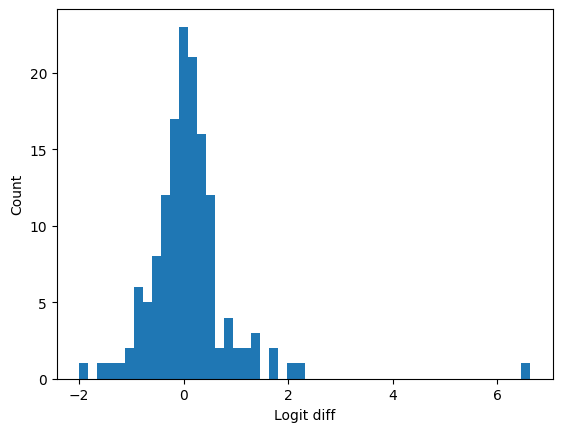

In [ ]:
# TODO: plot the Attention Head Histogram (by logit diff) using plt, with the count on the y-axis
plt.hist(logit_lens_diff.cpu().numpy(), bins = 50)
plt.xlabel('Logit diff')
plt.ylabel('Count')
plt.show()

#### 📊 2.5 ToShow
We can do the same thing with MLPs as well! Regenerate the same heatmap as before, but this time, add in a 13th column which represents the MLP.

In [ ]:
representations_mlp = torch.cat([
    torch.cat([
        gpt2_cache[f"blocks.{layer}.attn.hook_result"].mean(0)[-1],
        gpt2_cache[f"blocks.{layer}.hook_mlp_out"].mean(0)[-1].unsqueeze(0)
    ])
    for layer in range(12)], dim=0)

# Performing logit lens, and extracting she - he upweighting
logit_lenses = logit_lens(representations_mlp, unembed_matrix)

she_token_logit_lenses = logit_lenses[:, she_token]
he_token_logit_lenses = logit_lenses[:, he_token]
logit_lens_diff = she_token_logit_lenses - he_token_logit_lenses

heatmap_input = logit_lens_diff.view(12, 13)
px.imshow(heatmap_input.cpu(), color_continuous_scale='RdBu', zmin=-7, zmax=7, labels={'x':'head or mlp', 'y':'layer', 'color':'logit change'}, y=list(range(12)), x=[*(str(i) for i in range(12)), 'mlp'], width=800, height=600, title=f'Logit Diff by {xlabel} / {ylabel}')


## 3 Causal Analysis
Our prior analyses, though interesting, have failed to live up to the causal promise mentioned in the intro. Though our analyses have found heads that might potentially increase the probability of " she" over " he", neither of them proves that GPT-2 is using the heads found to do this. Moreover, the two analyses (attention and logit lens) seem to conflict—which of them, if either, is a correct explanation of how bias arises in GPT-2? Such observational techniques can almost never prove their own correctness, as they're only post-hoc interpretations of these models.

In contrast, causal methods allow us to test hypotheses regarding the causal structure of our model. To do so, we make changes to model internals during a forward pass, and observe how the model's behavior (as indicated by its logits) changes. For example, if we believe that an MLP upweights certain tokens, we can ablate (remove) it and see if those tokens receive less probability. We can also perform targeted replacements or alterations of activations that allow us to test more specific hypotheses. In the next section, we'll get a better idea of what these hypotheses might look like.

But first, we'll have to learn how to perform causal interventions; luckily TransformerLens provides us with easy tools for performing them.

### Intro to Causal Interventions in TransformerLens

TransformerLens supports causal interventions via a mechanism called `HookPoint`s. A `HookPoint` is associated with an output of a model component (i.e some operation in a model, like a matrix multiplication). Earlier, when we cached the outputs of GPT-2, what we were really doing is saving the output value of every `HookPoint`. When we retrieve an activation by name from the cache, we are actually naming the `HookPoint` from which it comes.

However, we can do more that just cache values with `HookPoint`s. We can change activation values by defining a `hook_fn` associated  with a `HookPoint`. A `hook_fn` takes as input the original output taken by the `HookPoint` (a `torch.Tensor`), as well as the `HookPoint`. It returns a new `torch.Tensor` to be used as output, replacing the original.

We then register the `hook_fn` to a specific `HookPoint` by name. When the model runs its forward pass, the `hook_fn` will receive the original output at that `HookPoint`, and the `HookPoint` itself; the model will then use the output of the `hook_fn` instead of the original output.

### First Causal Intervention: Zeroing
One way of determining if determining if a component is doing something important is to ablate it by replacing its output with zeros. If our hypothesis was correct, this zeroing should change model behavior with respect to what we thought the component was doing. In the following example, we show how to do this in TransformerLens: we're going to create a `hook_fn` that replaces the original output with a vector of zeros. Then, we'll run the model with this hook function, causing it to trigger at a specific head during the forward pass.


First we define our `hook_fn`. Then, we use the `fwd_hooks` argument of the  `model.run_with_hooks` function to run it. `fwd_hooks` takes in a list of `(hook_point_name, hook_fn)` tuples, so you can supply more than one at once.

We will target layer 10's head 9, at the end position, as we believe from the observational analysis that it contributes to gender biased output.

In [ ]:
layer_to_ablate = 10
head_index_to_ablate = 9

# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
#

def zero_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, -1, head_index_to_ablate, :] = 0.
    return value

original_probs = torch.softmax(model(female_stereo_toks, return_type="logits")[:, -1], dim=-1)
ablated_probs = torch.softmax(model.run_with_hooks(
    female_stereo_toks,
    return_type="logits",
    fwd_hooks=[(
        f'blocks.{layer_to_ablate}.attn.hook_result',
        zero_ablation_hook
        )]
    )[:, -1], dim=-1)
print(f"Original ' she' prob: {original_probs[:, she_token].mean().item():.3f}, Original ' he' prob: {original_probs[:, he_token].mean().item():.3f}")
print(f"Ablated ' she' prob: {ablated_probs[:, she_token].mean().item():.3f}, Ablated ' he' prob: {ablated_probs[:, he_token].mean().item():.3f}")

Shape of the value tensor: torch.Size([29, 5, 12, 768])
Original ' she' prob: 0.114, Original ' he' prob: 0.095
Ablated ' she' prob: 0.087, Ablated ' he' prob: 0.088


#### 🧠 3.1 ToThink
In the above experiment, we ablated the result vectors directly. Could we have zeroed another place to produce the same effect?

### Second Causal Intervention: Mean Ablation
Zero ablations are popular because they're easy to interpret, but they have some problems. Namely, zeros might be out of distribution for our network, which could rely on the fact that its representations are usually non-zero; perhaps the representation is used as a sort of constant. One way people get around this is to—instead of zero-ablating—**mean-ablate**: setting an activation vector to the mean vector of activations over the whole dataset.

#### ☑️ 3.2 ToDo
Write a hook function that performs mean ablation. That is, set the output of the targeted head (10,9) to the mean of its outputs over the whole dataset (stored in the cache, `gpt2_cache`).

In [ ]:
layer_to_ablate = 10
head_index_to_ablate = 9

def mean_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:

    # TODO: Write this part: get the relevant activation from gpt2_cache, and take the mean over examples
    print(hook.name)
    print(f"Shape of the value tensor: {value.shape}")
    # print(value[:, -1, head_index_to_ablate, :].shape)
    # print(torch.mean(value[:, -1, head_index_to_ablate, :], dim = 0).shape)
    print(value[:, -1, head_index_to_ablate, :].shape)
    print(torch.mean(value[:, -1, head_index_to_ablate, :], dim = 0).mean())
    print(gpt2_cache[hook.name][:, :, head_index_to_ablate, :].shape)
    print(torch.mean(gpt2_cache[hook.name][:, :, head_index_to_ablate, :], dim = (0, 1)).mean())
    # value[:, -1, head_index_to_ablate, :] = torch.mean(value[:, -1, head_index_to_ablate, :], dim = 0)
    assert (value == gpt2_cache[hook.name]).all()
    value[:, -1, head_index_to_ablate, :] = torch.mean(value[:, :, head_index_to_ablate, :], dim = (0, 1))
    return value

original_probs = torch.softmax(model(female_stereo_toks, return_type="logits")[:, -1], dim=-1)
ablated_probs = torch.softmax(model.run_with_hooks(
    female_stereo_toks,
    return_type="logits",
    fwd_hooks=[(
        f'blocks.{layer_to_ablate}.attn.hook_result',
        mean_ablation_hook
        )]
    )[:, -1], dim=-1)
print(f"Original ' she' prob: {original_probs[:, she_token].mean().item():.3f}, Original ' he' prob: {original_probs[:, he_token].mean().item():.3f}")
print(f"Ablated ' she' prob: {ablated_probs[:, she_token].mean().item():.3f}, Ablated ' he' prob: {ablated_probs[:, he_token].mean().item():.3f}")

blocks.10.attn.hook_result
Shape of the value tensor: torch.Size([29, 5, 12, 768])
torch.Size([29, 768])
tensor(-2.4835e-09, device='cuda:0')
torch.Size([29, 5, 768])
tensor(-4.6566e-09, device='cuda:0')
Original ' she' prob: 0.114, Original ' he' prob: 0.095
Ablated ' she' prob: 0.099, Ablated ' he' prob: 0.089


#### 🧠 3.3 ToThink ✍️
##### ✍️ ToSubmit 4
Submit the one line of code you used in the mean ablation hook.

This ablation doesn't work very well, even when implemented right! But this isn't a problem with ablation per se, but with the dataset we're taking the mean over. In no more than 3 sentences, describe the problem and a potential solution.

### Third Causal Intervention: Interchange Ablation
We proposed using mean ablations instead of zero ablations because of the out-of-distribution (OOD) issue. But, did this actually solve the problem? In fact, there is no guarantee that the mean of a set of activations is in-distribution - think of a [symmetric bimodal distribution](https://alanarnholt.github.io/PDS-Bookdown2/pds_files/figure-html/unnamed-chunk-17-2.png), where the mean is definitely OOD. Indeed, there is no constant value to which we can set activations to and avoid this problem.

The only way to get in-distribution activations is to use real in-distribution activations generated by the model. So, instead of zeroing out activations, or replacing them with their mean over a dataset, we'll try something new: we'll replace activations with other activations. Specifically, we'll replace the activations on the `female_stereo_toks` dataset with some taken from the `male_stereo_toks` dataset.

We know that in general, the `male_stereo_toks` dataset pushes the model to weight ' he' over ' she'. So, if we do this interchange ablation on an important head, it should cause our metrics, p(' she') and p(' he'), to shift.

#### ☑️ 3.4 ToDo
Finish the `replacement_ablation_hook` function below.

In [ ]:
layer_to_ablate = 10
head_index_to_ablate = 9

_, male_stereo_cache = model.run_with_cache(male_stereo_toks)

def replacement_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:

    # TODO: Write this part
    value_replace = male_stereo_cache[hook.name][:, -1, head_index_to_ablate, :]
    value_replace[torch.randperm(value_replace.size()[0])] # Row shuffling
    assert value[:, -1, head_index_to_ablate, :].shape == value_replace[:len(value)].shape
    value[:, -1, head_index_to_ablate, :] = value_replace[:len(value)]
    return value

original_probs = torch.softmax(model(female_stereo_toks, return_type="logits")[:, -1], dim=-1).mean(0)
ablated_probs = torch.softmax(model.run_with_hooks(
    female_stereo_toks,
    return_type="logits",
    fwd_hooks=[(
        f'blocks.{layer_to_ablate}.attn.hook_result',
        replacement_ablation_hook
        )]
    )[:, -1], dim=-1).mean(0)
print(f"Original ' she' prob: {original_probs[she_token].item():.3f}, Original ' he' prob: {original_probs[he_token].item():.3f}")
print(f"Ablated ' she' prob: {ablated_probs[she_token].item():.3f}, Ablated ' he' prob: {ablated_probs[he_token].item():.3f}")

Original ' she' prob: 0.114, Original ' he' prob: 0.095
Ablated ' she' prob: 0.086, Ablated ' he' prob: 0.121


This intervention is quite effective - it clearly decreases ' she' probability, and increases ' he' probability.

How about if we ablate a low-ranking head? Try one with a low logit lens score, but high attention score.

#### 📊 3.5 ToSubmit 5 ✍️
Last step! Like we've done before, iteratively ablate each head and make a heatmap showing how much they increased ' he' prob and decreased ' she' prob. **Submit the heatmap with a short caption describing what you see.**

In [ ]:
original_probs = torch.softmax(model(female_stereo_toks, return_type="logits")[:, -1], dim=-1).mean(0)
orig_prob_diff = original_probs[she_token] - original_probs[he_token]

def make_replacement_ablation_hook(head_index_to_ablate: int):
    def replacement_ablation_hook(
        value: Float[torch.Tensor, "batch pos head_index d_head"],
        hook: HookPoint
    ) -> Float[torch.Tensor, "batch pos head_index d_head"]:

        # TODO: Write this part
        # value[:, -1, head_index_to_ablate, :] = torch.mean(male_stereo_cache[hook.name][:, -1, head_index_to_ablate, :], dim = 0)
        value_replace = male_stereo_cache[hook.name][:, -1, head_index_to_ablate, :]
        value_replace[torch.randperm(value_replace.size()[0])] # Row shuffling
        assert value[:, -1, head_index_to_ablate, :].shape == value_replace[:len(value)].shape
        value[:, -1, head_index_to_ablate, :] = value_replace[:len(value)]
        return value
    return replacement_ablation_hook

prob_diffs = []
for layer_to_ablate in range(12):
    for head_index_to_ablate in range(12):
        ablated_probs = torch.softmax(model.run_with_hooks(
            female_stereo_toks,
            return_type="logits",
            fwd_hooks=[(
                f'blocks.{layer_to_ablate}.attn.hook_result',
                make_replacement_ablation_hook(head_index_to_ablate)
                )]
            )[:, -1], dim=-1).mean(0)
        prob_diff = ablated_probs[she_token] - ablated_probs[he_token]
        prob_diffs.append(prob_diff)

prob_diffs = torch.tensor(prob_diffs).to(device)
prob_change = orig_prob_diff.unsqueeze(0) - prob_diffs

px.imshow(prob_change.cpu().view(12,12), color_continuous_scale='RdBu', zmin=-0.05, zmax=0.05, labels={'x': 'head', 'y': 'layer', 'color':'prob diff'}, y=list(range(12)), x=list(range(12)), width=800, height=600, title=f'Prob Diff by {xlabel} / {ylabel}')

## 4 A Structured Approach to Mechanistic Interpretability via Circuits

You've now learned a number of methods that can be used to study transformer-based models. These methods have enabled us to examine attention heads and MLPs in both an observational and causal fashion. But how can we put these together to answer a specific research question? And what kind of answers can mechanistic interpretability give us?

In this final section, we introduce **circuits**, a class of causal hypotheses that we can use to explain model behavior. In this view, we treat models as directed acyclical graphs; the nodes of these graphs correspond to model components (attention heads and MLPs), and the edges indicate which nodes' outputs serve as inputs to each node in the graph. The goal of a circuits experiment is, given a model (computational graph) to find the minimal subgraph that suffices to replicate model behavior on a specific task.

Circuits are a useful abstraction of model behavior because they can tell us precisely which components matter to a certain task, and how the model performs that task. We can even verify them, by ablating all non-circuit nodes in the model, and testing that model behavior remains the same. In this section, we'll focus mainly on finding which nodes belong to a circuit (its structure); however, once we've found a circuit, we can also dig into what each head does (its semantics). All in all, circuits provide a much more organized view of what models do than other interpretability hypotheses.

### Circuit Theory

So what is a circuit, formally? In this section, we go over some necessary theory to understand what circuits are, and how to find them.

#### The Residual Stream
Before we start thinking of transformer based models as computational graphs, we first have to reframe how we view them. While it's typical to think of a model like GPT-2 as a feed-forward entity, where e.g. the transformer block in layer 4 receives as input, the output of the block in layer 3, there are better ways of thinking about it. One such way is the residual stream view.

Consider the fact that there is a residual connection around every attention layer and MLP layer. So, consider Attn 0, the first attention layer. It takes in the embeddings, and produces output, to which the embeddings are added via the residual stream. This serves as the input to MLP 0, the next component. Its output, plus the residual stream (Attn 0 + the embeddings), serves as the input to Attn 1, the next component.

In sum, the residual stream view tells us this: the input to each component is the sum of the outputs of all components before it (including the embeddings). Each component then adds its own output to that sum, which we call the residual stream. We can interpret this as each component reading from and writing to this stream. This stream also serves as input to the final LayerNorm and unembedding operation that produces the logits.

Some research interprets this, in the context of language models, as the model creating and continually updating a distribution over its vocabulary. The residual stream represents this intermediate distribution (which can be accessed via logit lens). The output of each component (also viewable through the logit lens) is thus an update to this distribution, which is iteratively refined over the course of the model.

![](https://39669.cdn.cke-cs.com/rQvD3VnunXZu34m86e5f/images/c7052b9cfde21fd125b70380c3289ddab77b50cde834556c.png/w_1380)

#### Models as Computational Graphs
Now that we realize that every component's input is the sum of the prior components' outputs, it's easy to see how they can be viewed as a directed acyclical graph. Every component is a node; upstream nodes (nodes earlier in the model) have edges pointing to downstream components (those later than them in the model).

This view is nice, as it makes very explicit the wide variety of influences that one node has on the rest of the model. In the diagram, we can clearly see that MLP 10 has both a direct effect on the logits (via its direct connection thereto) and an indirect effect, via Attn 11 and MLP 11.

As we search for circuits, we're going to try to find the minimal subgraph of our model that preserves its task performance. That means we want to eliminate not only nodes from the graph, but also edges. That is, we'll make claims like "Attn 7 is important, but only insofar as it influences MLPs 7 and 8". So, the specific paths by which nodes do or don't act on other nodes is crucial.

#### Circuit Examples

So what does a circuit look like anyway? Unfortunately, we don't have a circuit for gender bias to show you (that's for you to find yourself!). But, here is an example circuit, that demonstrates what kind of insights circuits could give us.

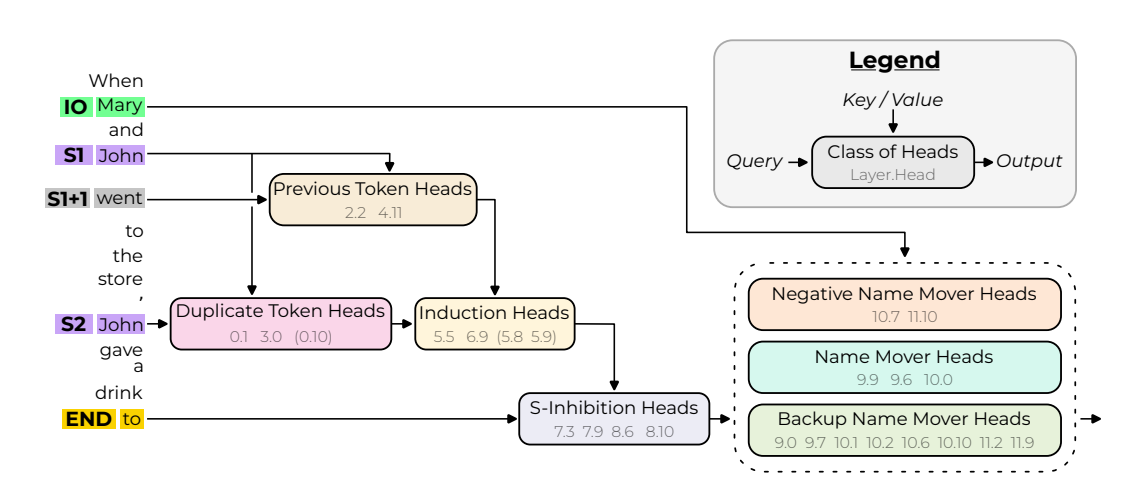

Here, we have a circuit that explains why, given input like "When Mary and John went to the store, John gave a drink to", GPT-2 assigns higher probability to " Mary" than " John".

Each node in the circuit is a group of attention heads. Within each node, each head does the same task; for example, the (backup) name mover heads increase the probability of " Mary". The Previous Token Heads, Duplicate Token Heads, and Induction Heads, work together to decide that " John" would be a bad next word. They serve as input to the S-Inhibition Heads, which tells the name movers what to downweight at the END.

You don't have to understand the whole circuit—that will be hard without reading the [whole paper](https://arxiv.org/pdf/2211.00593.pdf). But hopefully, seeing this diagram helps you understand the class of hypotheses that a circuit represents, and what kind of findings we hope that you uncover over the course of your investigations.

### Finding Circuits

In theory, finding circuits is not difficult. In practice, however, it can be quite tricky to manage the direct and indirect effects of an intervention in TransformerLens. That said, TransformerLens still allows us a degree of low-level control over models that is unparalleled by most other frameworks.

#### Theory

In order to find a circuit, we can apply a simple algorithm. First, we define a metric, which represents the phenomenon we're interested in, and which we'd like to find a circuit for. In this case, our metric will be $p($ `' she'` $) - p($ `' he'` $)$, but it could easily be something more complex. We'll also define two datasets: one normal dataset (this is our `female_stereo_toks`), and one dataset that produces the opposite behavior with respect to the phenomenon (`male_stereo_toks`).

Then, we will iteratively look for edges that are important to the model's behavior on this task. We start by ablating the components' direct connections with the logits (every component has one). If the model performance changes (drops) when we ablate a direct connection, we know that the ablated edge was important, and is thus part of the circuit. We can set a threshold for how much performance should drop for an edge to be in the circuit. Since we are ablating direct edges, we can know what each component directly contributes to the task, without getting confused by its effects via other components.

We continue this process iteratively, working our way upstream (starting at the output). We examine one of the nodes that directly contributes to the logits and ask: what other nodes contribute to the circuit via this node? We answer this question by again ablating the components' contributions to the circuit via their direct connections with this node. We add edges of nodes whose ablations caused drops in performance, and repeat.

```
Algorithm
---
baseline_performance: float = run_model(dataset)
circuit: Set = {}  # edges representing our circuit
unexplored_nodes: Set[Node] = {logits}  # nodes we are yet to explore

while unexplored_nodes is not empty:
    target: Node = pop_furthest_downstream_node(unexplored_nodes)
    for source: Node in nodes_upstream_of(target):
        ablated_performance: float = run_model_with_ablated_connection(source, target, circuit, dataset)
        if baseline_performance - ablated_performance > threshold:
            circuit.add((source, target))
            unexplored_nodes.add(source)

return circuit
```

After we've found a circuit, we then prove it is correct by ablating all edges not in the circuit. This means that most of the model's activations will correspond to activations from the ablation dataset. Only those edges in our circuit will actually be activations from the non-ablation dataset.

#### Practice

In practice, ablating direct and indirect connections is rather tricky in TransformerLens. Since there is no distinction in these models between the direct effects of a component on another component, vs. its indirect effects, we must recreate this ourself.

We can do this as follows. Say we want to ablate the direct connection between $A$ and the logits. We can first run the model twice: once on our original dataset, and once on our ablation dataset. We store the direct outputs of $A$ as `a_original` and `a_ablation`.

Then, we run the model one more time on the original dataset, but this time, we hook into the inputs of logits. By the residual stream view, the input to logits is simply the sum of all prior components' outputs, including that of $A$. We subtract `a_original` from logits's inputs, and add `a_ablation`. In this way we have ablated the connection between $A\rightarrow$logits, without propagating the ablation of $A$ anywhere else via indirect effects.

#### 📊 4.1 ToSubmit 6 ✍️
Implement direct ablations, and use them to iteratively test which heads / MLPs most contribute to the task. This will be very similar to the prior experiment. **Hand in the heat map we plot at the end of the code with a one-sentence caption describing what you see.**

In [ ]:
from typing import Literal

sampling_indices = torch.randint(0, male_stereo_toks.size(0), (female_stereo_toks.size(0),))
_, original_cache = model.run_with_cache(female_stereo_toks)
_, ablated_cache = model.run_with_cache(male_stereo_toks[sampling_indices])

def make_final_residual_stream_hook(original_value: torch.Tensor, new_value: torch.Tensor):
    def final_residual_stream_hook(value: Float[torch.Tensor, "batch pos d_residual"], hook: HookPoint):
        # TODO: one-liner; just return the updated value of the final residual stream as described in the last paragraph of the prior section
        # Only update the end / final position

        # print(value.shape, original_value.shape, new_value.shape, hook.name)

        # value[hook.name][:, -1, :] = - original_value[hook.name][:, -1, :] + new_value[hook.name][:, -1, :]
        # value[:, -1, :] = value[:, -1, :] - original_value[:, -1, :] + new_value[:, -1, :]
        # print(value[:, -1, :].shape, original_value.shape, new_value.shape)
        value[:, -1, :] = value[:, -1, :] - original_value[:, -1, :] + new_value[:, -1, :]
        # value = value - original_value + new_value
        return value
    return final_residual_stream_hook


def direct_ablation(layer: int, head_or_mlp: Union[Literal['mlp'], int]) -> torch.Tensor:
    # TODO: retrieve the correct values A_original and A_ablation. Then, run the model with the hook you've implemented above to get new logits

    def get_output_from_cache(cache: ActivationCache, layer:int, head_or_mlp: Union[int, Literal['mlp']]) -> torch.Tensor:
        if head_or_mlp == 'logits':
            raise ValueError("Just use the actual logits")
        elif head_or_mlp == 'mlp':
            return cache[f'blocks.{layer}.hook_mlp_out']
        else:
            return cache[f'blocks.{layer}.attn.hook_result'][:, :, head_or_mlp]


    if head_or_mlp == 'mlp':
        hook = f"blocks.{layer}.hook_mlp_out"
    else:
        hook = f"blocks.{layer}.attn.hook_result"

    A_original = get_output_from_cache(original_cache, layer, head_or_mlp)#[:, -1, :]
    A_ablation =  get_output_from_cache(ablated_cache, layer, head_or_mlp)#[:, -1, :]

    # if head_or_mlp != 'mlp':
    #     A_original = A_original[:, :, head_or_mlp, :]
    #     A_ablation = A_ablation[:, :, head_or_mlp, :]

    final_hook = make_final_residual_stream_hook(A_original, A_ablation)

    direct_logits = model.run_with_hooks(
        female_stereo_toks,
        return_type="logits",
        fwd_hooks=[(
            'blocks.11.hook_resid_post',
            # f'blocks.{layer+1}.hook_resid_post',
            # hook,
            final_hook
            )]
    )
    return direct_logits




prob_diffs = []
for layer in range(12):
    for head_or_mlp in [*range(12), 'mlp']:
        direct_logits = direct_ablation(layer, head_or_mlp)
        direct_probs = torch.softmax(direct_logits, dim=-1).mean(0)[-1]
        prob_diff = direct_probs[she_token] - direct_probs[he_token]
        prob_diffs.append(prob_diff)
prob_diffs = torch.tensor(prob_diffs).to(device)
prob_change = prob_diffs - orig_prob_diff.unsqueeze(0)
prob_change = prob_change.view(12, 13)
px.imshow(prob_change.cpu(), color_continuous_scale='RdBu', zmin=-0.06, zmax=0.06, labels={'x':'head or mlp', 'y':'layer', 'color':'prob diff change'}, y=list(range(12)), x=[*(str(i) for i in range(12)), 'mlp'], width=800, height=600, title='Prob Diff Change by Layer / Head')


Based on this diagram, we can identify a set of heads and MLPs that are likely important to this task. That is, we've taken the first step towards identifying a circuit! But how do we know if our circuit was correct?

### Proving Circuit Correctness

We've only found a little bit of a circuit so far, not the whole thing. But the underlying idea of ablating all non-circuit nodes is the same.

Here, we do just that: we store both normal and ablated activations. Then, we run the model on the ablated dataset. However, for those nodes in the circuit connected directly to the logits, we hook into the logit inputs, and subtracting out the ablated activations, and adding in the original activations. We compare performance to the original and ablated scenarios.

In [ ]:
sampling_indices = torch.randint(0, male_stereo_toks.size(0), (female_stereo_toks.size(0),))
orig_logits, original_cache = model.run_with_cache(female_stereo_toks)
ablated_logits, ablated_cache = model.run_with_cache(male_stereo_toks[sampling_indices])

def get_output_from_cache(cache: ActivationCache, layer:int, head_or_mlp: Union[int, Literal['mlp']]) -> torch.Tensor:
    if head_or_mlp == 'logits':
        raise ValueError("Just use the actual logits")
    elif head_or_mlp == 'mlp':
        return cache[f'blocks.{layer}.hook_mlp_out']
    else:
        return cache[f'blocks.{layer}.attn.hook_result'][:, :, head_or_mlp]

circuit = [(10, 9), (9, 7), (11, 8), (10, 'mlp'), (9, 'mlp'), (9, 2), (8, 11), (8, 'mlp'), (4,3), (6,0)]

original_values = torch.sum(torch.stack([get_output_from_cache(ablated_cache, *component) for component in circuit]), dim=0)
new_values = torch.sum(torch.stack([get_output_from_cache(original_cache, *component) for component in circuit]), dim=0)

circuit_logits = model.run_with_hooks(
        male_stereo_toks[sampling_indices],
        return_type="logits",
        fwd_hooks=[(
            "blocks.11.hook_resid_post",
            make_final_residual_stream_hook(original_values, new_values)
            )]
        )

for name, logits in zip(['original prob diff', 'ablated prob diff', 'circuit prob diff'], [orig_logits, ablated_logits, circuit_logits]):
    probs = torch.softmax(logits, dim=-1).mean(0)[-1]
    prob_diff = probs[she_token] - probs[he_token]
    print(f'{name}: {prob_diff:0.3f}')


original prob diff: 0.020
ablated prob diff: -0.089
circuit prob diff: 0.032


It looks like our circuit is correct! Even though most of the model is seeing our `male_stereo_toks`, since the circuit components are getting `female_stereo_toks`, the whole is behaving like it is receiving `female_stereo_toks`.

## 5 Wrap-Up

Hopefully by now you have learned how to use the TransformerLens library to identify components in a GPT-2 model responsible for producing gender biased output.
In this workshop, you have studied these components in both an observational and causal fashion, and have seen that those do not necessarily lead to the same conclusions.
You have also become familiar with the idea of *circuits*, a way of framing low-level interpretations of what a model does and how.
We hope that -- if you intend to do your last project on mechanistic interpretability -- this new framework helps you in exploring new hypotheses about the behaviour and representations learned by Transformer models!

**Here are some example project ideas, but feel free to come with your own:**
- Are gender stereotypes and grammatical gender represented by the same components/circuits in a GPT-2 model?
- Does intervening at the identified components result in a diminished bias score on some other benchmark/task?
- Are the TransformerLens results consistent across different sentences/sentence structures? (I.e. How contextual are these circuits? Is there redundancy in how this behaviour is encoded?)
- How do the results compare to other approaches (e.g., attribution methods; check out the [Inseq library](https://github.com/inseq-team/inseq))?
- Does debiasing the model via finetuning on a more balanced dataset especially affect the identified circuits?


# 6. Bonus

Congratulations on finishing this notebook! Mechanistic interpretability is a large field, though, and we've only scratched the surface of it. Here are some more interesting lines of work that you might want to look into when you're done with this.

- Anthropic's work on mech. interp.:
    - [A Mathematical Framework for Circuits](https://www.anthropic.com/index/a-mathematical-framework-for-transformer-circuits), and a [recent update](https://www.anthropic.com/index/circuits-updates-may-2023)
    - [Induction Heads](https://www.anthropic.com/index/in-context-learning-and-induction-heads)
    - [Superposition](https://www.anthropic.com/index/toy-models-of-superposition) and [SoLU](https://www.anthropic.com/index/softmax-linear-units)
    - [Privileged Bases in the Residual Stream](https://www.anthropic.com/index/privileged-bases-in-the-transformer-residual-stream)
- Chris Olah's [blog posts](https://distill.pub/2020/circuits/) on circuits in ConvNets, which spurred much of current mech. interp. research:
- Work from Redwood Research:
    - [IOI](https://arxiv.org/abs/2211.00593), [Greater-than](https://t.co/ZN6zWjlaaI)
    - [Causal Scrubbing](https://www.alignmentforum.org/posts/JvZhhzycHu2Yd57RN/causal-scrubbing-a-method-for-rigorously-testing)
    - [Path Patching](https://arxiv.org/abs/2304.05969)
    - [Automated Circuit Discovery](https://arxiv.org/abs/2304.14997)
    - [rust-circuit](https://github.com/redwoodresearch/rust_circuit_public), another interpretability framework
- [ROME](https://arxiv.org/pdf/2202.05262.pdf) and this [follow-up](https://arxiv.org/pdf/2301.04213.pdf)
-  Neel Nanda's
    - [Work on grokking](https://openreview.net/forum?id=9XFSbDPmdW)
    - [Follow up](https://www.neelnanda.io/mechanistic-interpretability/othello) to the Othello paper discussed during the course.
- Other recent work by [Mor Geva](https://scholar.google.com/citations?user=GxpQbSkAAAAJ&hl=en)


If you're looking for more notebooks or practice with TransformerLens, have a look at these:
- [Original Demo Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb)
- [Induction Heads Notebook](https://colab.research.google.com/drive/17i8LctAgVLTJ883Nyo8VIEcCNeKNCYnr?usp=share_link)
- [Parentheses Balancer Notebook](https://colab.research.google.com/drive/1puoiNww84IAEgkUMI0PnWp_aL1vai707?usp=sharing)

### More complicated ablation paths through the computational graph

Curious how to make more complicated ablation paths through the computational graph in TransformerLens? Check this out:

In [ ]:
HeadOrMLP: type = Union[Literal['logits'], Literal['mlp'], Tuple[int, Union[Literal['q'],Literal['k'],Literal['v'],None]]]
Node: type = Tuple[int, HeadOrMLP, int]
# A node is a triple of (layer, 'logits' / 'mlp' / (Head #, q/k/v), position)

def assert_valid_path(path: List[Node]) -> None:
    # asserts that a path is valid (by this I mean that for every pair of nodes in the path, the first node has an effect on the second)
    for source, target in zip(path, path[1:]):
        source_layer, source_head_or_mlp, source_position = source
        target_layer, target_head_or_mlp, target_position = target
        if target_head_or_mlp == 'logits':
            if source_position != target_position:
                raise ValueError(f"Path from {source} to {target} has mismatched position (invalid for logit target)")
        elif target_head_or_mlp == 'mlp':
            if source_position != target_position:
                raise ValueError(f"Path from {source} to {target} has mismatched position (invalid for mlp target)")
            if source_layer > target_layer:
                raise ValueError(f"Path from {source} to {target} has source layer > target layer (invalid for mlp target)")
        else:
            if source_layer > target_layer:
                raise ValueError(f"Path from {source} to {target} has source layer >= target layer (invalid for attn target)")

def is_upstream_of(u: Node, v: Node) -> bool:
    # checks if node u is upstream of node v
    u_layer, u_head_or_mlp, _ = u
    v_layer, v_head_or_mlp, _ = v
    if u_head_or_mlp == 'logits':
        return False
    elif v_head_or_mlp == 'logits':
        return True
    elif v_head_or_mlp == 'mlp':
        return (u_layer < v_layer) or ((u_layer == v_layer) and (u_head_or_mlp != 'mlp'))
    else:
        return u_layer < v_layer

def get_output_from_cache(cache: ActivationCache, layer:int, head_or_mlp: HeadOrMLP, position:int) -> torch.Tensor:
    # given specification of a node, get the activations thereof from the cache
    if head_or_mlp == 'logits':
        raise ValueError("Just use the actual logits")
    elif head_or_mlp == 'mlp':
        return cache[f'blocks.{layer}.hook_mlp_out']
    else:
        head, stream = head_or_mlp
        return cache[f'blocks.{layer}.attn.hook_result'][:, :, head]

def intervene_on_input(layer:int,
                       head_or_mlp: HeadOrMLP,
                       position: int,
                       original: Float[torch.Tensor, "batch pos d_residual position"],
                       ablated: Float[torch.Tensor, "batch pos d_residual position"]):

    """
    Given a target layer and head, and a position in its input, modifies the input, subtracting out original and adding in ablated.
    """

    def residual_stream_hook(value: Float[torch.Tensor, "batch pos d_residual"], hook: HookPoint):
        value[:, position] = value[:, position] - original[:, position] + ablated[:, position]
        return value
    if head_or_mlp == 'logits':
        name = "blocks.11.hook_resid_post"
    elif head_or_mlp == 'mlp':
        name = f"blocks.{layer}.ln2.hook_normalized"
    else:
        head, stream = head_or_mlp
        if stream is None:
            name = f"blocks.{layer}.ln1.hook_normalized"
        else:
            name = f"blocks.{layer}.attn.hook_{stream}"
    return name, residual_stream_hook

# Each tuple is (layer, head, position)
def path_ablation(path: List[Node], original_toks, ablation_toks) -> torch.Tensor:
    """
    Given a path (list of nodes), original toks, and ablation toks, performs an interchange ablation.
    The effects of this ablation will propagate only through the specified path.
    """
    assert_valid_path(path)
    _, original_cache = model.run_with_cache(original_toks)
    ablated_logits, ablated_cache = model.run_with_cache(ablation_toks)

    for source_info, target_info in zip(path, path[1:]):
        # get original
        original = get_output_from_cache(original_cache, *source_info)
        # get ablated
        ablated = get_output_from_cache(ablated_cache, *source_info)

        # create and add hook
        _, _, source_position = source_info
        target_layer, target_head_or_mlp, _ = target_info
        model.add_hook(*intervene_on_input(target_layer, target_head_or_mlp, source_position, original, ablated))

        # run_with_hooks, propagating the ablation
        ablated_logits, ablated_cache = model.run_with_cache(original_toks)
        model.reset_hooks()
    return ablated_logits

In [ ]:
try:
    profession_position = 2
    end_position = -1
    path = [(10, (9, None), end_position), (11, 'logits', end_position)]
    prob_diffs = []
    for layer in range(12):
        for head_or_mlp in [*zip(range(12), (None,) * 12), 'mlp']:
            if is_upstream_of((layer, head_or_mlp, profession_position), path[0]):
                path_logits = path_ablation([(layer, head_or_mlp, profession_position)] + path, female_stereo_toks, male_stereo_toks[sampling_indices])
                path_probs = torch.softmax(path_logits, dim=-1).mean(0)[-1]
                prob_diff = path_probs[she_token] - path_probs[he_token]
            else:
                prob_diff = orig_prob_diff
            prob_diffs.append(prob_diff)
    prob_diffs = torch.tensor(prob_diffs).to(device)
    prob_change = prob_diffs - orig_prob_diff.unsqueeze(0)
    prob_change = prob_change.view(12, 13)
    fig = px.imshow(prob_change.cpu(), color_continuous_scale='RdBu', zmin=-0.06, zmax=0.06, labels={'x':'head or mlp', 'y':'layer', 'color':'prob diff change'}, y=list(range(12)), x=[*(str(i) for i in range(12)), 'mlp'], width=800, height=600, title='Prob Diff Change by Layer / Head')
    fig.show()
except Exception as e:
    print(layer, head_or_mlp)
    model.reset_hooks()
    raise e